# Фаза 2 • Неделя 10 • Вторник
## Обработка естественного языка
#### Word2Vec • LSTM • Attention

#### Задание 1
Реализуй класс `BahdanauAttention` и обучи модель с Attention в двух вариантах: 
1. LSTM + Word2Vec + BahdanauAttention
2. LSTM + Trainable Embedding + BahdanauAttention
3. Распечатай графики изменения функций потерь и метрик во время обучения для сравнения. 

Схема механизма внимания Bahdanau (если картинка не открывается – вот её путь: `10-nlp/aux/bahdanau-att.png`)

<div>
<img src="aux/bahdanau-att.png" width="500"/>
</div>


In [1]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import os

#### Word2Vec
import gensim
from gensim.models import Word2Vec

####
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchutils as tu
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
)

from src.rnn_preprocessing import (
    data_preprocessing,
    preprocess_single_string,
    padding,
    get_words_by_freq,
)

from src.fit_model import fit_model, fit_with_mlflow, plot_history, binary_metrics

print(gensim.__version__)

/mnt/data/elbrus/Phase2_continue/ds-phase-2-cont-git/week3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.3.3


In [2]:
import multiprocessing as mp
from dataclasses import dataclass
from typing import Union
from tqdm.auto import tqdm
import mlflow
from time import time

In [3]:
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# GENERATOR = (
#     torch.Generator(device=DEVICE) if torch.cuda.is_available() else torch.Generator()
# )
GENERATOR = torch.Generator()

use_mlflow = True
mlflow.set_tracking_uri("http://localhost:5000")

plt.rcParams["figure.dpi"] = 200
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
df = pd.read_csv("data/imdb.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
reviews = df["review"].tolist()
preprocessed = [data_preprocessing(review) for review in reviews]

In [7]:
corpus = [word for text in preprocessed for word in text.split()]
sorted_words = Counter(corpus).most_common()
sorted_words = get_words_by_freq(sorted_words, 200)
sorted_words[-10:]

[('loads', 201),
 ('myers', 201),
 ('walken', 201),
 ('failing', 201),
 ('honesty', 201),
 ('dozens', 201),
 ('superficial', 201),
 ('reunion', 201),
 ('vegas', 201),
 ('todd', 201)]

In [8]:
vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}

In [9]:
list(vocab_to_int.items())[:10]

[('movie', 1),
 ('film', 2),
 ('not', 3),
 ('one', 4),
 ('like', 5),
 ('good', 6),
 ('even', 7),
 ('no', 8),
 ('would', 9),
 ('time', 10)]

In [10]:
reviews_int = []
for text in preprocessed:
    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)
print([i for i in reviews_int[0]])
print(preprocessed[0])

[4, 1794, 936, 58, 3187, 286, 349, 2999, 109, 480, 469, 21, 59, 3070, 3187, 52, 471, 182, 109, 547, 54, 1591, 3, 43, 43, 2340, 8, 1326, 276, 471, 3229, 246, 233, 353, 3187, 240, 2398, 934, 2462, 1236, 420, 2356, 1072, 2806, 298, 3, 213, 3535, 420, 236, 2301, 224, 36, 128, 9, 47, 168, 1162, 43, 549, 93, 161, 156, 434, 2820, 700, 86, 1133, 2334, 970, 700, 1271, 700, 60, 848, 89, 21, 286, 45, 105, 3070, 1437, 2051, 288, 47, 1408, 176, 1323, 1112, 3187, 90, 213, 1933, 1945, 471, 3, 471, 2776, 379, 498, 16, 142, 15, 629, 690, 541, 1072, 549, 437, 804, 1844, 1072, 442, 58, 3187, 100, 302, 3568, 3087, 16, 1075, 3824, 391]
one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experi

In [11]:
w2v_input = []
for review in preprocessed:
    cur_review = []
    for word in review.split():
        if vocab_to_int.get(word):
            cur_review.append(word)
    w2v_input.append(cur_review)
print(f"Total reviews: {len(w2v_input)}")
print(f"Random review for word2vec: {w2v_input[np.random.randint(0, 50000)]}")

Total reviews: 50000
Random review for word2vec: ['classic', 'musical', 'todd', 'not', 'production', 'justice', 'still', 'quite', 'enjoyable', 'aspect', 'version', 'production', 'design', 'excellent', 'right', 'main', 'failing', 'performances', 'people', 'give', 'oh', 'theyre', 'believable', 'right', 'quite', 'nobody', 'seems', 'hitting', 'time', 'song', 'say', 'kiss', 'fact', 'actress', 'playing', 'not', 'degree', 'also', 'slightly', 'angela', 'slightly', 'overdone', 'accent', 'bit', 'irritating', 'one', 'thing', 'exactly', 'bad', 'judge', 'performance', 'american', 'theatre', 'not', 'little', 'excellent', 'production', 'thrill', 'watch', 'people', 'love', 'im', 'not', 'even', 'talking', 'meat', 'twist']


In [70]:
VOCAB_SIZE = len(vocab_to_int) + 1  # размер словаря вместе с токеном padding
EMBEDDING_DIM = 64  # embedding_dim
VOCAB_SIZE

3917

In [13]:
# Обучим Word2Vec
wv = Word2Vec(vector_size=EMBEDDING_DIM)  # размерность вектора для слова
# Сначала word2vec составляет словарь
wv.build_vocab(w2v_input)
print(f"Total reviews: {wv.corpus_count}")

Total reviews: 50000


In [14]:
wv.train(corpus_iterable=w2v_input, total_examples=wv.corpus_count, epochs=10)

(42816378, 46110850)

In [69]:
wv.save("weights/W2V_weights/W2V_model.model")

In [15]:
# Создаем слой эмбеддинга
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Бежим по всем словам словаря: если слово есть в word2vec,
# достаем его вектор; если слова нет, то распечатываем его и пропускаем
for word, i in vocab_to_int.items():
    try:
        embedding_vector = wv.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        pass
        print(f"{e}: word: {word}")

In [16]:
# Создаем предобученный эмбеддинг – этот слой в нашей сети обучаться не будет
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
print(f"Number of words x EMEDDING_DIM: {embedding_matrix.shape}")

Number of words x EMEDDING_DIM: (3916, 64)


In [17]:
padded = padding(review_int=reviews_int, seq_len=64)

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    np.array(padded),
    pd.get_dummies(df["sentiment"], drop_first=True).values.astype("int"),
    test_size=0.2,
    random_state=1,
)

In [19]:
BATCH_SIZE = 64
HIDDEN_SIZE = 32
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [39]:
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)
valid_loader = DataLoader(
    valid_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)

In [67]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print(
    "Sample input size: BATCH_SIZE x SEQ_LEN", sample_x.size()
)  # batch_size, seq_length
print("Sample input: \n", sample_x)
print("Sample input: \n", sample_y[:10])

Sample input size: BATCH_SIZE x SEQ_LEN torch.Size([64, 64])
Sample input: 
 tensor([[ 896,  208, 3313,  ..., 1382,  204,    7],
        [3136,  175,  863,  ..., 2651,   89,  925],
        [ 196,  365,  327,  ...,  441, 3354,  494],
        ...,
        [   0,    0,    0,  ..., 1784,  337,  736],
        [1365,    2,   75,  ...,    3,   18,  208],
        [   3,    5, 1634,  ..., 1742,  787,  386]])
Sample input: 
 tensor([[1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]])


In [34]:
BATCH_SIZE = 64
HIDDEN_SIZE = 32
SEQ_LEN = 64


class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size: int = HIDDEN_SIZE) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.linear_key = nn.Linear(hidden_size, hidden_size)
        self.linear_query = nn.Linear(hidden_size, hidden_size)
        self.cls = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, lstm_outputs, final_hidden):
        # print(f"LSTM output shape: {lstm_outputs.shape}")
        # print(f"Final_hidden shape: {final_hidden.shape}")
        keys = self.linear_key(lstm_outputs)  # (batch_size, seq_len, hidden_size)
        # print(f"After linear keys shape: {keys.shape}")
        query = self.linear_query(final_hidden)  # (batch_size, hidden_size)
        query = query.unsqueeze(1)  # (batch_size, 1, hidden_size)
        # print(f"After linear query shape: {query.shape}")
        x = self.tanh(keys + query)  # (batch_size, seq_len, hidden_size)
        # print(f"After + X shape: {x.shape}")
        x = self.cls(x)  # (batch_size, seq_len, 1)
        # print(f"After cls x shape: {x.shape}")
        x = x.squeeze(-1)  # (batch_size, seq_len)
        # print(f"After squeeze x shape: {x.shape}")
        attention_weights = F.softmax(x, dim=-1)  # (batch_size, seq_len)
        # print(f"Attention weights shape: {attention_weights.shape}")
        attention_weights_bmm = attention_weights.unsqueeze(
            1
        )  # (batch_size, 1, seq_len)
        # print(f"Attention weights for bmm shape: {attention_weights_bmm.shape}")

        # bmm : (batch_size, 1, seq_len) * (batch_size, seq_len, hidden_size) = (batch_size, 1, hidden_size)
        context = torch.bmm(attention_weights_bmm, keys)  # (batch_size, 1, hidden_size)
        # print(f"Context shape: {context.shape}")
        context = context.squeeze(1)
        # print(f"Context final shape: {context.shape}")

        return context, attention_weights

In [135]:
BahdanauAttention()(
    torch.randn(BATCH_SIZE, SEQ_LEN, HIDDEN_SIZE), torch.randn(BATCH_SIZE, HIDDEN_SIZE)
)

(tensor([[-0.1735,  0.0614, -0.1689,  ...,  0.1609, -0.0134,  0.1921],
         [ 0.0046, -0.0793, -0.1693,  ...,  0.2571, -0.0503, -0.0161],
         [-0.1726,  0.1700, -0.2426,  ...,  0.2597, -0.0397,  0.0580],
         ...,
         [-0.1247,  0.0429, -0.0189,  ...,  0.1881, -0.0095,  0.0569],
         [-0.0776, -0.0233, -0.0976,  ...,  0.1324, -0.0413,  0.0361],
         [-0.0693, -0.1705, -0.0666,  ...,  0.1243, -0.0410,  0.0242]],
        grad_fn=<SqueezeBackward1>),
 tensor([[0.0140, 0.0200, 0.0237,  ..., 0.0239, 0.0163, 0.0188],
         [0.0141, 0.0173, 0.0136,  ..., 0.0142, 0.0179, 0.0154],
         [0.0145, 0.0116, 0.0213,  ..., 0.0146, 0.0105, 0.0223],
         ...,
         [0.0167, 0.0144, 0.0176,  ..., 0.0131, 0.0182, 0.0161],
         [0.0190, 0.0153, 0.0155,  ..., 0.0190, 0.0146, 0.0124],
         [0.0157, 0.0116, 0.0167,  ..., 0.0209, 0.0125, 0.0157]],
        grad_fn=<SoftmaxBackward0>))

In [136]:
attention = BahdanauAttention(HIDDEN_SIZE)

In [137]:
tu.get_model_summary(
    attention, torch.randn(16, 32, HIDDEN_SIZE), torch.randn(16, HIDDEN_SIZE)
)

Layer             Kernel       Output      Params       FLOPs
0_linear_key     [32, 32]   [16, 32, 32]    1,056   1,032,192
1_linear_query   [32, 32]       [16, 32]    1,056      32,256
2_tanh                  -   [16, 32, 32]        0      81,920
3_cls             [32, 1]    [16, 32, 1]       33      32,256
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
Total FLOPs: 1,178,624 / 1.18 MFLOPs
-------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.26
Params size (MB): 0.01
Estimated Total Size (MB): 0.33


In [35]:
@dataclass
class Config:
    n_layers: int
    embedding_size: int
    hidden_size: int
    vocab_size: int = VOCAB_SIZE
    device: str = DEVICE
    seq_len: int = SEQ_LEN
    bidirectional: Union[bool, int] = False

In [36]:
my_config = Config(
    n_layers=4,
    embedding_size=64,
    hidden_size=32,
    vocab_size=VOCAB_SIZE,
    device=DEVICE,
    seq_len=64,
    bidirectional=False,
)


class LSTMBahdanauAttention(nn.Module):
    def __init__(self, config=my_config) -> None:
        super().__init__()

        # инициализируем конфиг
        self.config = config
        self.seq_len = self.config.seq_len
        self.vocab_size = self.config.vocab_size
        self.hidden_size = self.config.hidden_size
        self.emb_size = self.config.embedding_size
        self.n_layers = self.config.n_layers
        self.device = self.config.device
        self.bidirectional = bool(self.config.bidirectional)

        self.embedding = embedding_layer
        self.lstm = nn.LSTM(self.emb_size, self.hidden_size, batch_first=True)
        self.bidirect_factor = 2 if self.bidirectional == 1 else 1
        self.attn = BahdanauAttention(self.hidden_size)
        self.clf = nn.Sequential(
            nn.Linear(self.hidden_size, 128), nn.Dropout(), nn.Tanh(), nn.Linear(128, 1)
        )

    def model_description(self):
        direction = "bidirect" if self.bidirectional else "onedirect"
        return f"rnn_{direction}_{self.n_layers}"

    def forward(self, x):
        embeddings = self.embedding(x)
        outputs, (h_n, _) = self.lstm(embeddings)
        # att_hidden, att_weights = self.attn(outputs, h_n[-1].squeeze(0))
        att_hidden, att_weights = self.attn(outputs, h_n[-1])
        out = self.clf(att_hidden)
        return out, att_weights

In [40]:
model_ban = LSTMBahdanauAttention(config=my_config)
model_ban = model_ban.to(my_config.device)
criterion = nn.BCEWithLogitsLoss()
LR_BAN = 1e-4
WEIGHT_DECAY_BAN = 3e-4
optim_ban = torch.optim.AdamW(
    model_ban.parameters(), lr=LR_BAN, weight_decay=WEIGHT_DECAY_BAN
)

In [41]:
logs, total_time, run = fit_with_mlflow(
    model=model_ban,
    model_name="LSTM+BahdanauAtt",
    epochs=15,
    criterion=criterion,
    optimizer=optim_ban,
    train_loader=train_loader,
    valid_loader=valid_loader,
    device=my_config.device,
    batch_size=BATCH_SIZE,
    lr=LR_BAN,
)

начало обучения...
------------- Epoch 1 -------------


Epoch 1/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 59.51it/s] 


Train stage: loss:  0.550  Accuracy:  0.717  Precision:  0.710  Recall:  0.773  F1-score:  0.733  
Valid stage: loss:  0.415  Accuracy:  0.807  Precision:  0.768  Recall:  0.873  F1-score:  0.815  
Time: 10.558648824691772
-----------------------------------

------------- Epoch 2 -------------


Epoch 2/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 51.03it/s] 


Train stage: loss:  0.395  Accuracy:  0.824  Precision:  0.807  Recall:  0.853  F1-score:  0.827  
Valid stage: loss:  0.375  Accuracy:  0.834  Precision:  0.824  Recall:  0.846  F1-score:  0.833  
Time: 11.431986808776855
-----------------------------------

------------- Epoch 3 -------------


Epoch 3/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 49.27it/s] 


Train stage: loss:  0.369  Accuracy:  0.838  Precision:  0.828  Recall:  0.855  F1-score:  0.839  
Valid stage: loss:  0.361  Accuracy:  0.843  Precision:  0.838  Recall:  0.848  F1-score:  0.841  
Time: 11.982066869735718
-----------------------------------

------------- Epoch 4 -------------


Epoch 4/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 46.91it/s] 


Train stage: loss:  0.355  Accuracy:  0.843  Precision:  0.835  Recall:  0.855  F1-score:  0.843  
Valid stage: loss:  0.355  Accuracy:  0.844  Precision:  0.821  Recall:  0.877  F1-score:  0.846  
Time: 11.593687295913696
-----------------------------------

------------- Epoch 5 -------------


Epoch 5/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 49.16it/s] 


Train stage: loss:  0.348  Accuracy:  0.847  Precision:  0.840  Recall:  0.857  F1-score:  0.846  
Valid stage: loss:  0.348  Accuracy:  0.848  Precision:  0.834  Recall:  0.868  F1-score:  0.849  
Time: 11.864054679870605
-----------------------------------

------------- Epoch 6 -------------


Epoch 6/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 51.40it/s] 


Train stage: loss:  0.343  Accuracy:  0.849  Precision:  0.843  Recall:  0.859  F1-score:  0.849  
Valid stage: loss:  0.345  Accuracy:  0.849  Precision:  0.834  Recall:  0.869  F1-score:  0.849  
Time: 11.73890495300293
-----------------------------------

------------- Epoch 7 -------------


Epoch 7/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 52.32it/s] 


Train stage: loss:  0.337  Accuracy:  0.853  Precision:  0.846  Recall:  0.862  F1-score:  0.852  
Valid stage: loss:  0.341  Accuracy:  0.852  Precision:  0.843  Recall:  0.863  F1-score:  0.851  
Time: 11.432136535644531
-----------------------------------

------------- Epoch 8 -------------


Epoch 8/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 53.14it/s] 


Train stage: loss:  0.334  Accuracy:  0.854  Precision:  0.848  Recall:  0.863  F1-score:  0.854  
Valid stage: loss:  0.340  Accuracy:  0.853  Precision:  0.839  Recall:  0.871  F1-score:  0.852  
Time: 11.297006368637085
-----------------------------------

------------- Epoch 9 -------------


Epoch 9/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 49.43it/s] 


Train stage: loss:  0.330  Accuracy:  0.856  Precision:  0.849  Recall:  0.866  F1-score:  0.856  
Valid stage: loss:  0.337  Accuracy:  0.855  Precision:  0.852  Recall:  0.858  F1-score:  0.853  
Time: 11.299047470092773
-----------------------------------

------------- Epoch 10 -------------


Epoch 10/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 49.57it/s] 


Train stage: loss:  0.327  Accuracy:  0.858  Precision:  0.853  Recall:  0.868  F1-score:  0.858  
Valid stage: loss:  0.336  Accuracy:  0.855  Precision:  0.846  Recall:  0.866  F1-score:  0.854  
Time: 11.991719722747803
-----------------------------------

------------- Epoch 11 -------------


Epoch 11/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 49.90it/s] 


Train stage: loss:  0.324  Accuracy:  0.859  Precision:  0.853  Recall:  0.868  F1-score:  0.859  
Valid stage: loss:  0.334  Accuracy:  0.855  Precision:  0.843  Recall:  0.869  F1-score:  0.854  
Time: 11.329003095626831
-----------------------------------

------------- Epoch 12 -------------


Epoch 12/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 53.00it/s] 


Train stage: loss:  0.320  Accuracy:  0.860  Precision:  0.856  Recall:  0.868  F1-score:  0.860  
Valid stage: loss:  0.334  Accuracy:  0.857  Precision:  0.858  Recall:  0.852  F1-score:  0.853  
Time: 10.892032146453857
-----------------------------------

------------- Epoch 13 -------------


Epoch 13/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 54.47it/s] 


Train stage: loss:  0.318  Accuracy:  0.862  Precision:  0.857  Recall:  0.870  F1-score:  0.862  
Valid stage: loss:  0.333  Accuracy:  0.857  Precision:  0.845  Recall:  0.872  F1-score:  0.856  
Time: 11.379040718078613
-----------------------------------

------------- Epoch 14 -------------


Epoch 14/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 47.77it/s] 


Train stage: loss:  0.315  Accuracy:  0.864  Precision:  0.858  Recall:  0.873  F1-score:  0.863  
Valid stage: loss:  0.332  Accuracy:  0.857  Precision:  0.841  Recall:  0.875  F1-score:  0.855  
Time: 11.716106653213501
-----------------------------------

------------- Epoch 15 -------------


Epoch 15/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 48.85it/s] 


Train stage: loss:  0.313  Accuracy:  0.865  Precision:  0.861  Recall:  0.872  F1-score:  0.864  
Valid stage: loss:  0.330  Accuracy:  0.858  Precision:  0.850  Recall:  0.866  F1-score:  0.856  
Time: 11.914002180099487
-----------------------------------

Total time = 172.4 сек
🏃 View run LSTM+BahdanauAtt_BS = 64_lr_0.0001 at: http://localhost:5000/#/experiments/876301535260986920/runs/ee5cd013220f4f72940d685cedae5c7a
🧪 View experiment at: http://localhost:5000/#/experiments/876301535260986920


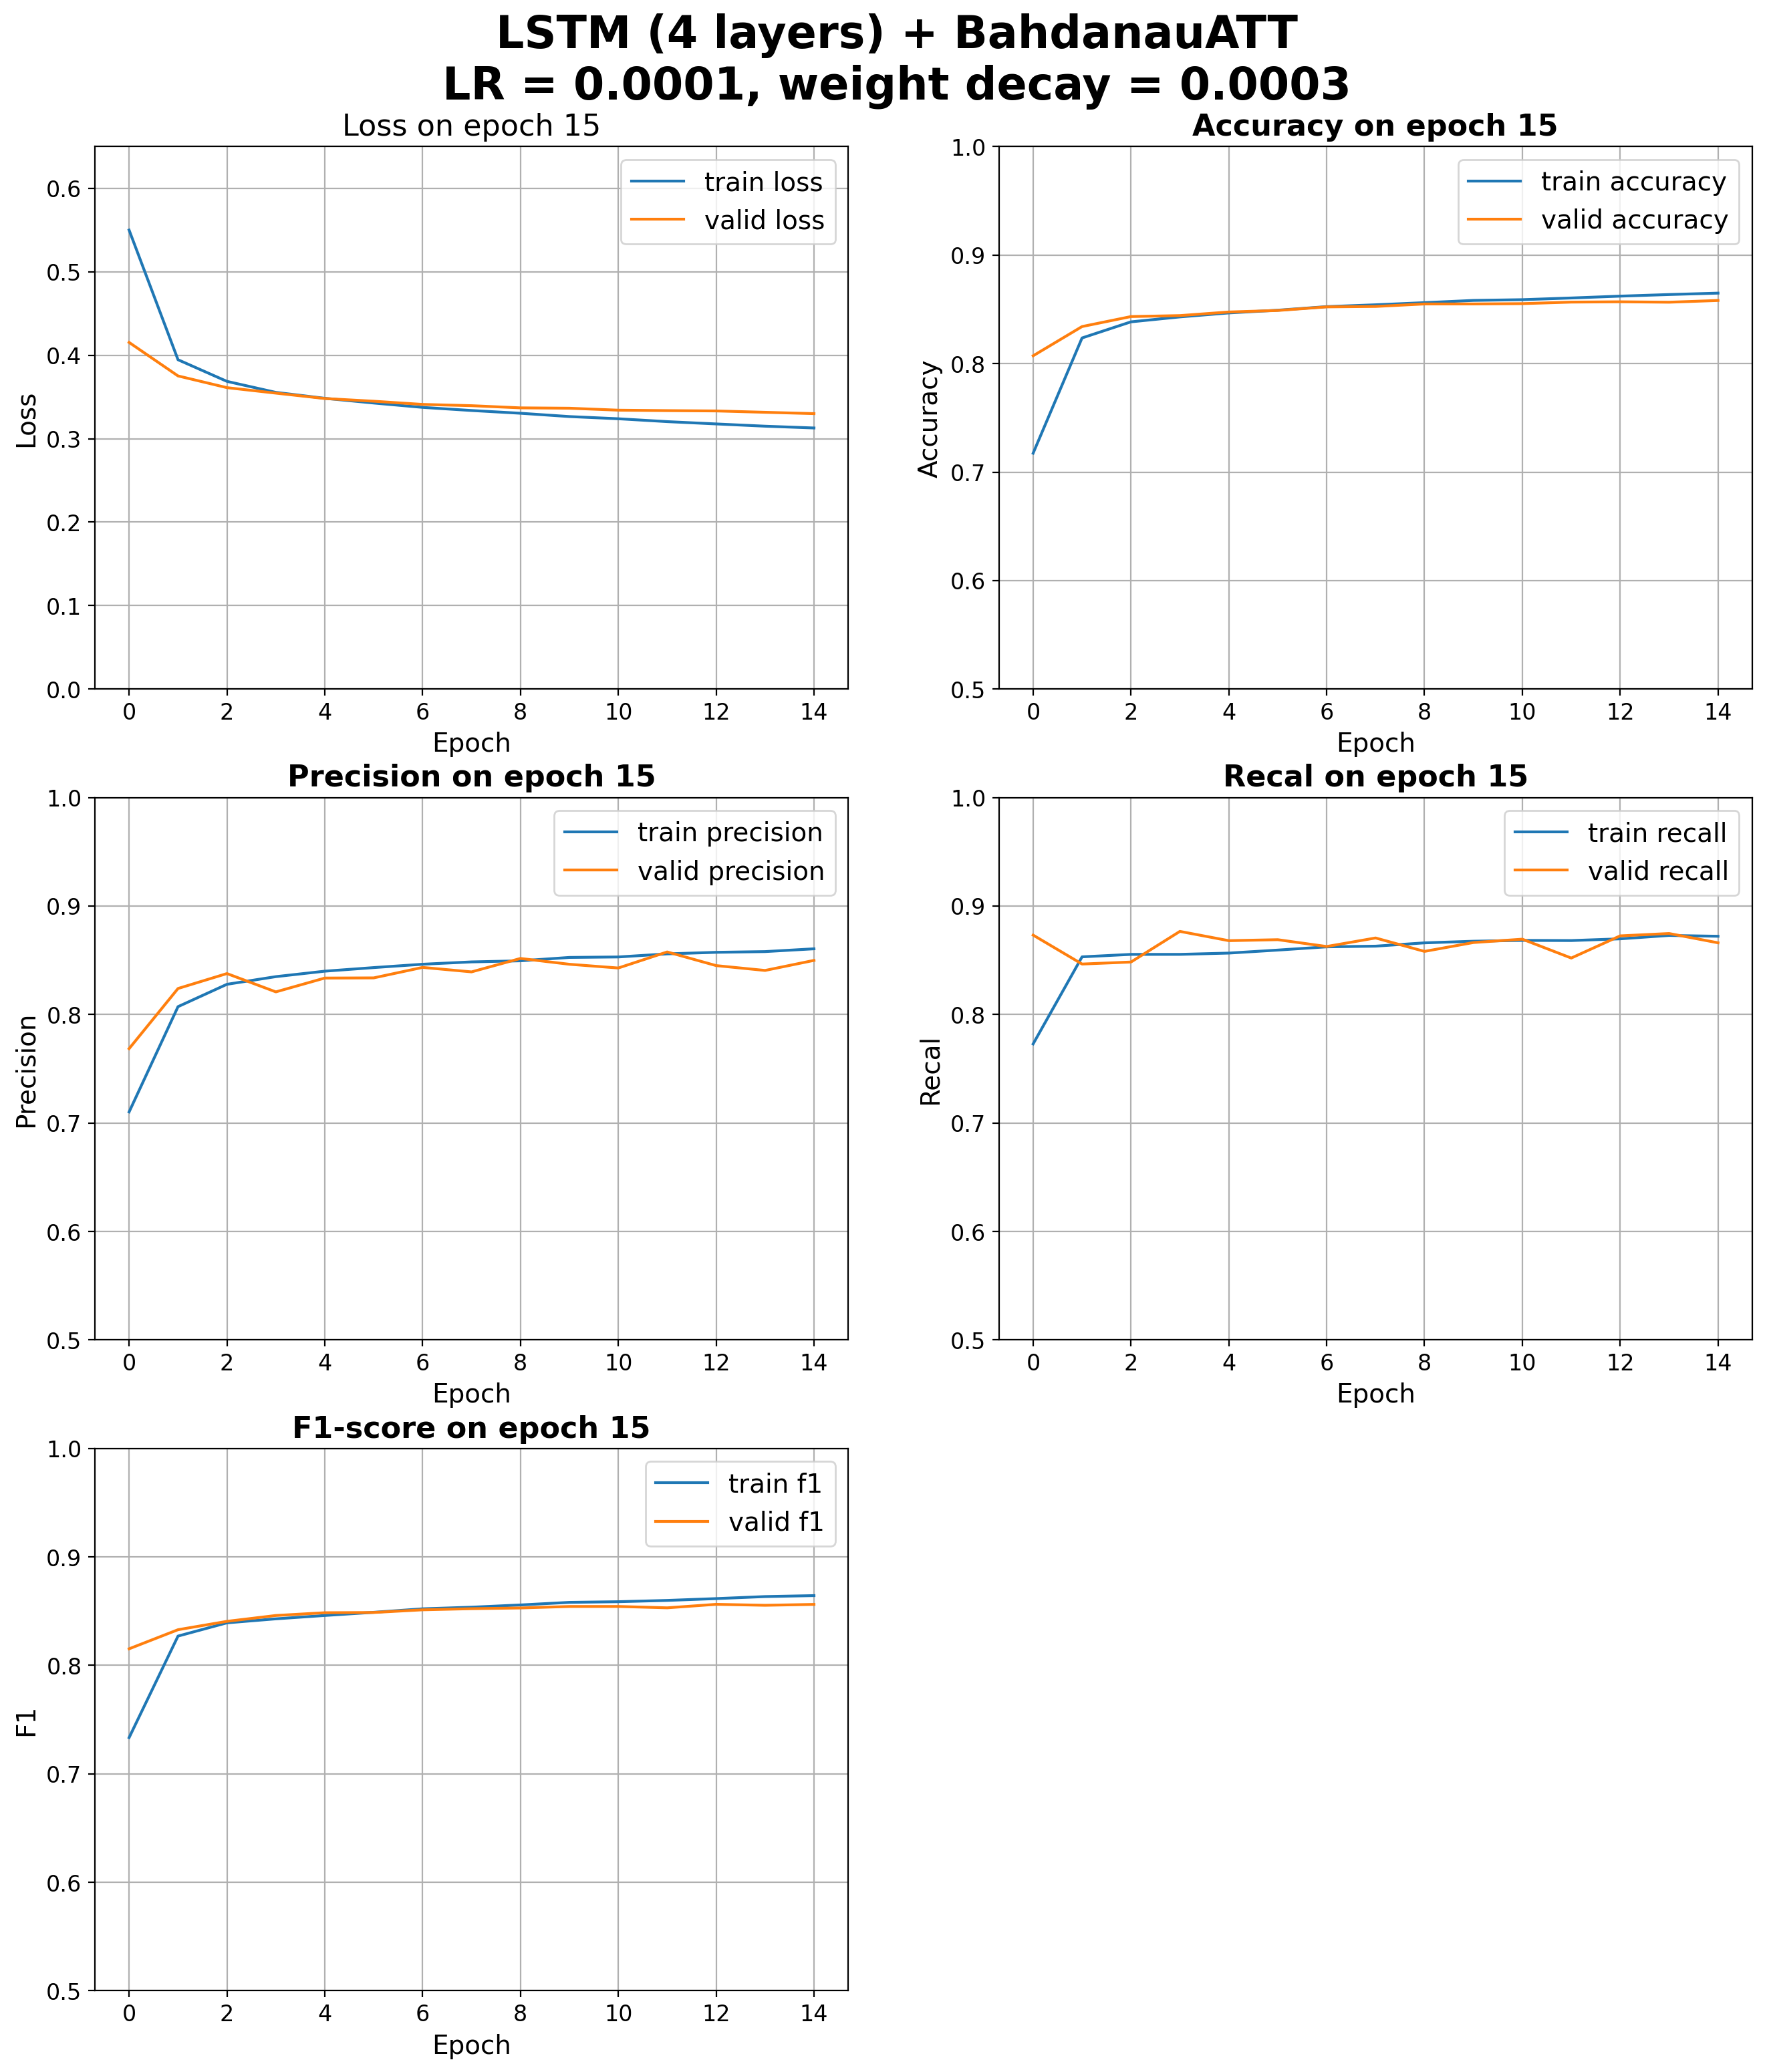

In [68]:
fig_1 = plot_history(
    logs,
    suptitle=f"LSTM ({my_config.n_layers} layers) + BahdanauATT\nLR = {LR_BAN}, weight decay = {WEIGHT_DECAY_BAN}",
)

In [ ]:
# fig_1.savefig(
#     f"results/LSTM ({my_config.n_layers} layers) + BahdanauATT\nLR = {LR_BAN}, weight decay = {WEIGHT_DECAY_BAN}.png",
#     bbox_inches="tight",
# )

In [64]:
def predict_sentence(text: str, model: nn.Module, weights_path: str) -> str:
    input = (
        preprocess_single_string(text, seq_len=SEQ_LEN, vocab_to_int=vocab_to_int)
        .long()
        .unsqueeze(0)
    )
    # print(f"Тензор на вход модели {input.shape}")
    state_dict = torch.load(weights_path, map_location="cpu")
    model.to("cpu")
    model.load_state_dict(state_dict)
    model.eval()

    with torch.inference_mode():
        output, _ = model(input)
        prob = output.squeeze().sigmoid().item()
    if prob > 0.5:
        Class = 1
        result = "Positive feedback"
    else:
        Class = 0
        result = "Negative feedback"
    return Class, prob, result

In [65]:
test_weights = "weights/LSTM+BahdanauAtt/run_11/weight_epoch_15.pth"

In [129]:
review = "Worst movie I have ever seen"
Class, prob, result = predict_sentence(review, model_ban, test_weights)
print(Class, prob, result)

Тензор на вход модели torch.Size([1, 64])
LSTM output shape: torch.Size([1, 64, 32])
Final_hidden shape: torch.Size([1, 32])
After linear keys shape: torch.Size([1, 64, 32])
After linear query shape: torch.Size([1, 1, 32])
0 0.015673812478780746 Negative feedback


In [146]:
n = 10
rand_reviews = df["review"].sample(n=10, random_state=42)
rand_reviews = rand_reviews.reset_index()
rand_reviews["Class"] = rand_reviews["review"].map(
    lambda x: predict_sentence(x, model_ban, test_weights)[0]
)
rand_reviews["Probability"] = rand_reviews["review"].map(
    lambda x: predict_sentence(x, model_ban, test_weights)[1]
)
rand_reviews["Result"] = rand_reviews["review"].map(
    lambda x: predict_sentence(x, model_ban, test_weights)[2]
)
rand_reviews["True_label"] = pd.Series(
    [df.loc[c, "sentiment"] for c in rand_reviews["index"]]
)
# rand_reviews.drop("index", inplace=True, axis=1)
rand_reviews

,index,review,Class,Probability,Result,True_label
0,33553,I really liked this Summerslam due to the look...,0,0.017273,Negative feedback,positive
1,9427,Not many television shows appeal to quite as m...,1,0.645689,Positive feedback,positive
2,199,The film quickly gets to a major chase scene w...,0,0.077526,Negative feedback,negative
3,12447,Jane Austen would definitely approve of this o...,1,0.977690,Positive feedback,positive
4,39489,Expectations were somewhat high for me when I ...,0,0.261878,Negative feedback,negative
5,42724,I've watched this movie on a fairly regular ba...,1,0.692719,Positive feedback,positive
6,10822,For once a story of hope highlighted over the ...,1,0.998384,Positive feedback,positive
7,49498,"Okay, I didn't get the Purgatory thing the fir...",1,0.509707,Positive feedback,positive
8,4144,I was very disappointed with this series. It h...,0,0.078759,Negative feedback,negative
9,36958,The first 30 minutes of Tinseltown had my fing...,0,0.072414,Negative feedback,negative


In [20]:
train_loader_2 = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)
valid_loader_2 = DataLoader(
    valid_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)

In [25]:
class LSTMBahdanauAttention_2(nn.Module):
    def __init__(self, config=my_config) -> None:
        super().__init__()

        # инициализируем конфиг
        self.config = config
        self.seq_len = self.config.seq_len
        self.vocab_size = self.config.vocab_size
        self.hidden_size = self.config.hidden_size
        self.emb_size = self.config.embedding_size
        self.n_layers = self.config.n_layers
        self.device = self.config.device
        self.bidirectional = bool(self.config.bidirectional)

        self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
        self.lstm = nn.LSTM(self.emb_size, self.hidden_size, batch_first=True)
        self.bidirect_factor = 2 if self.bidirectional == 1 else 1
        self.attn = BahdanauAttention(self.hidden_size)
        self.clf = nn.Sequential(
            nn.Linear(self.hidden_size, 128), nn.Dropout(), nn.Tanh(), nn.Linear(128, 1)
        )

    def model_description(self):
        direction = "bidirect" if self.bidirectional else "onedirect"
        return f"rnn_{direction}_{self.n_layers}"

    def forward(self, x):
        embeddings = self.embedding(x)
        outputs, (h_n, _) = self.lstm(embeddings)
        # att_hidden, att_weights = self.attn(outputs, h_n[-1].squeeze(0))
        att_hidden, att_weights = self.attn(outputs, h_n[-1])
        out = self.clf(att_hidden)
        return out, att_weights

In [27]:
model_ban_2 = LSTMBahdanauAttention(config=my_config)
model_ban_2 = model_ban_2.to(my_config.device)
criterion_2 = nn.BCEWithLogitsLoss()
LR_BAN_2 = 3e-5
WEIGHT_DECAY_BAN_2 = 3e-4
optim_ban_2 = torch.optim.AdamW(
    model_ban_2.parameters(), lr=LR_BAN_2, weight_decay=WEIGHT_DECAY_BAN_2
)

In [29]:
logs_2, total_time_2, run_2 = fit_with_mlflow(
    model=model_ban_2,
    model_name="LSTM+BahdanauAtt_2",
    epochs=15,
    criterion=criterion_2,
    optimizer=optim_ban_2,
    train_loader=train_loader_2,
    valid_loader=valid_loader_2,
    device=my_config.device,
    batch_size=BATCH_SIZE,
    lr=LR_BAN_2,
)

начало обучения...
------------- Epoch 1 -------------


Epoch 1/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 61.77it/s] 


Train stage: loss:  0.437  Accuracy:  0.803  Precision:  0.782  Recall:  0.841  F1-score:  0.808  
Valid stage: loss:  0.411  Accuracy:  0.811  Precision:  0.789  Recall:  0.846  F1-score:  0.814  
Time: 10.160698652267456
-----------------------------------

------------- Epoch 2 -------------


Epoch 2/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 52.61it/s] 


Train stage: loss:  0.405  Accuracy:  0.818  Precision:  0.800  Recall:  0.849  F1-score:  0.822  
Valid stage: loss:  0.396  Accuracy:  0.821  Precision:  0.804  Recall:  0.845  F1-score:  0.822  
Time: 11.117794513702393
-----------------------------------

------------- Epoch 3 -------------


Epoch 3/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 52.96it/s] 


Train stage: loss:  0.391  Accuracy:  0.824  Precision:  0.809  Recall:  0.849  F1-score:  0.826  
Valid stage: loss:  0.386  Accuracy:  0.827  Precision:  0.804  Recall:  0.860  F1-score:  0.830  
Time: 11.062831163406372
-----------------------------------

------------- Epoch 4 -------------


Epoch 4/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 53.17it/s] 


Train stage: loss:  0.382  Accuracy:  0.830  Precision:  0.817  Recall:  0.853  F1-score:  0.832  
Valid stage: loss:  0.379  Accuracy:  0.832  Precision:  0.816  Recall:  0.852  F1-score:  0.831  
Time: 11.190905332565308
-----------------------------------

------------- Epoch 5 -------------


Epoch 5/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 51.45it/s] 


Train stage: loss:  0.376  Accuracy:  0.833  Precision:  0.821  Recall:  0.854  F1-score:  0.835  
Valid stage: loss:  0.374  Accuracy:  0.836  Precision:  0.827  Recall:  0.848  F1-score:  0.835  
Time: 11.202877759933472
-----------------------------------

------------- Epoch 6 -------------


Epoch 6/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 49.05it/s] 


Train stage: loss:  0.371  Accuracy:  0.836  Precision:  0.825  Recall:  0.853  F1-score:  0.836  
Valid stage: loss:  0.369  Accuracy:  0.838  Precision:  0.825  Recall:  0.854  F1-score:  0.837  
Time: 11.372897863388062
-----------------------------------

------------- Epoch 7 -------------


Epoch 7/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 52.28it/s] 


Train stage: loss:  0.367  Accuracy:  0.837  Precision:  0.827  Recall:  0.854  F1-score:  0.838  
Valid stage: loss:  0.366  Accuracy:  0.840  Precision:  0.828  Recall:  0.855  F1-score:  0.839  
Time: 11.232839822769165
-----------------------------------

------------- Epoch 8 -------------


Epoch 8/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 54.75it/s] 


Train stage: loss:  0.363  Accuracy:  0.839  Precision:  0.831  Recall:  0.853  F1-score:  0.840  
Valid stage: loss:  0.363  Accuracy:  0.840  Precision:  0.822  Recall:  0.864  F1-score:  0.840  
Time: 11.08280611038208
-----------------------------------

------------- Epoch 9 -------------


Epoch 9/15 [Test]: 100%|██████████| 156/156 [00:02<00:00, 52.40it/s] 


Train stage: loss:  0.360  Accuracy:  0.841  Precision:  0.832  Recall:  0.856  F1-score:  0.842  
Valid stage: loss:  0.361  Accuracy:  0.843  Precision:  0.835  Recall:  0.852  F1-score:  0.841  
Time: 11.30593752861023
-----------------------------------

------------- Epoch 10 -------------


Epoch 10/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 48.45it/s] 


Train stage: loss:  0.357  Accuracy:  0.842  Precision:  0.835  Recall:  0.854  F1-score:  0.842  
Valid stage: loss:  0.359  Accuracy:  0.842  Precision:  0.825  Recall:  0.865  F1-score:  0.843  
Time: 11.918039321899414
-----------------------------------

------------- Epoch 11 -------------


Epoch 11/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 47.41it/s] 


Train stage: loss:  0.355  Accuracy:  0.844  Precision:  0.835  Recall:  0.857  F1-score:  0.844  
Valid stage: loss:  0.357  Accuracy:  0.844  Precision:  0.830  Recall:  0.862  F1-score:  0.844  
Time: 11.96494436264038
-----------------------------------

------------- Epoch 12 -------------


Epoch 12/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 44.36it/s] 


Train stage: loss:  0.352  Accuracy:  0.845  Precision:  0.838  Recall:  0.857  F1-score:  0.845  
Valid stage: loss:  0.355  Accuracy:  0.845  Precision:  0.836  Recall:  0.854  F1-score:  0.843  
Time: 12.197917461395264
-----------------------------------

------------- Epoch 13 -------------


Epoch 13/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 50.50it/s] 


Train stage: loss:  0.350  Accuracy:  0.845  Precision:  0.838  Recall:  0.858  F1-score:  0.846  
Valid stage: loss:  0.353  Accuracy:  0.845  Precision:  0.838  Recall:  0.853  F1-score:  0.843  
Time: 11.658854961395264
-----------------------------------

------------- Epoch 14 -------------


Epoch 14/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 50.76it/s] 


Train stage: loss:  0.348  Accuracy:  0.846  Precision:  0.839  Recall:  0.858  F1-score:  0.846  
Valid stage: loss:  0.351  Accuracy:  0.846  Precision:  0.829  Recall:  0.867  F1-score:  0.845  
Time: 11.893699407577515
-----------------------------------

------------- Epoch 15 -------------


Epoch 15/15 [Test]: 100%|██████████| 156/156 [00:03<00:00, 50.66it/s] 


Train stage: loss:  0.347  Accuracy:  0.848  Precision:  0.841  Recall:  0.860  F1-score:  0.848  
Valid stage: loss:  0.350  Accuracy:  0.847  Precision:  0.836  Recall:  0.859  F1-score:  0.845  
Time: 11.790096759796143
-----------------------------------

Total time = 171.2 сек
🏃 View run LSTM+BahdanauAtt_2_BS = 64_lr_3e-05 at: http://localhost:5000/#/experiments/733614799898931131/runs/57e813f0fce84150b11ba780468b024c
🧪 View experiment at: http://localhost:5000/#/experiments/733614799898931131


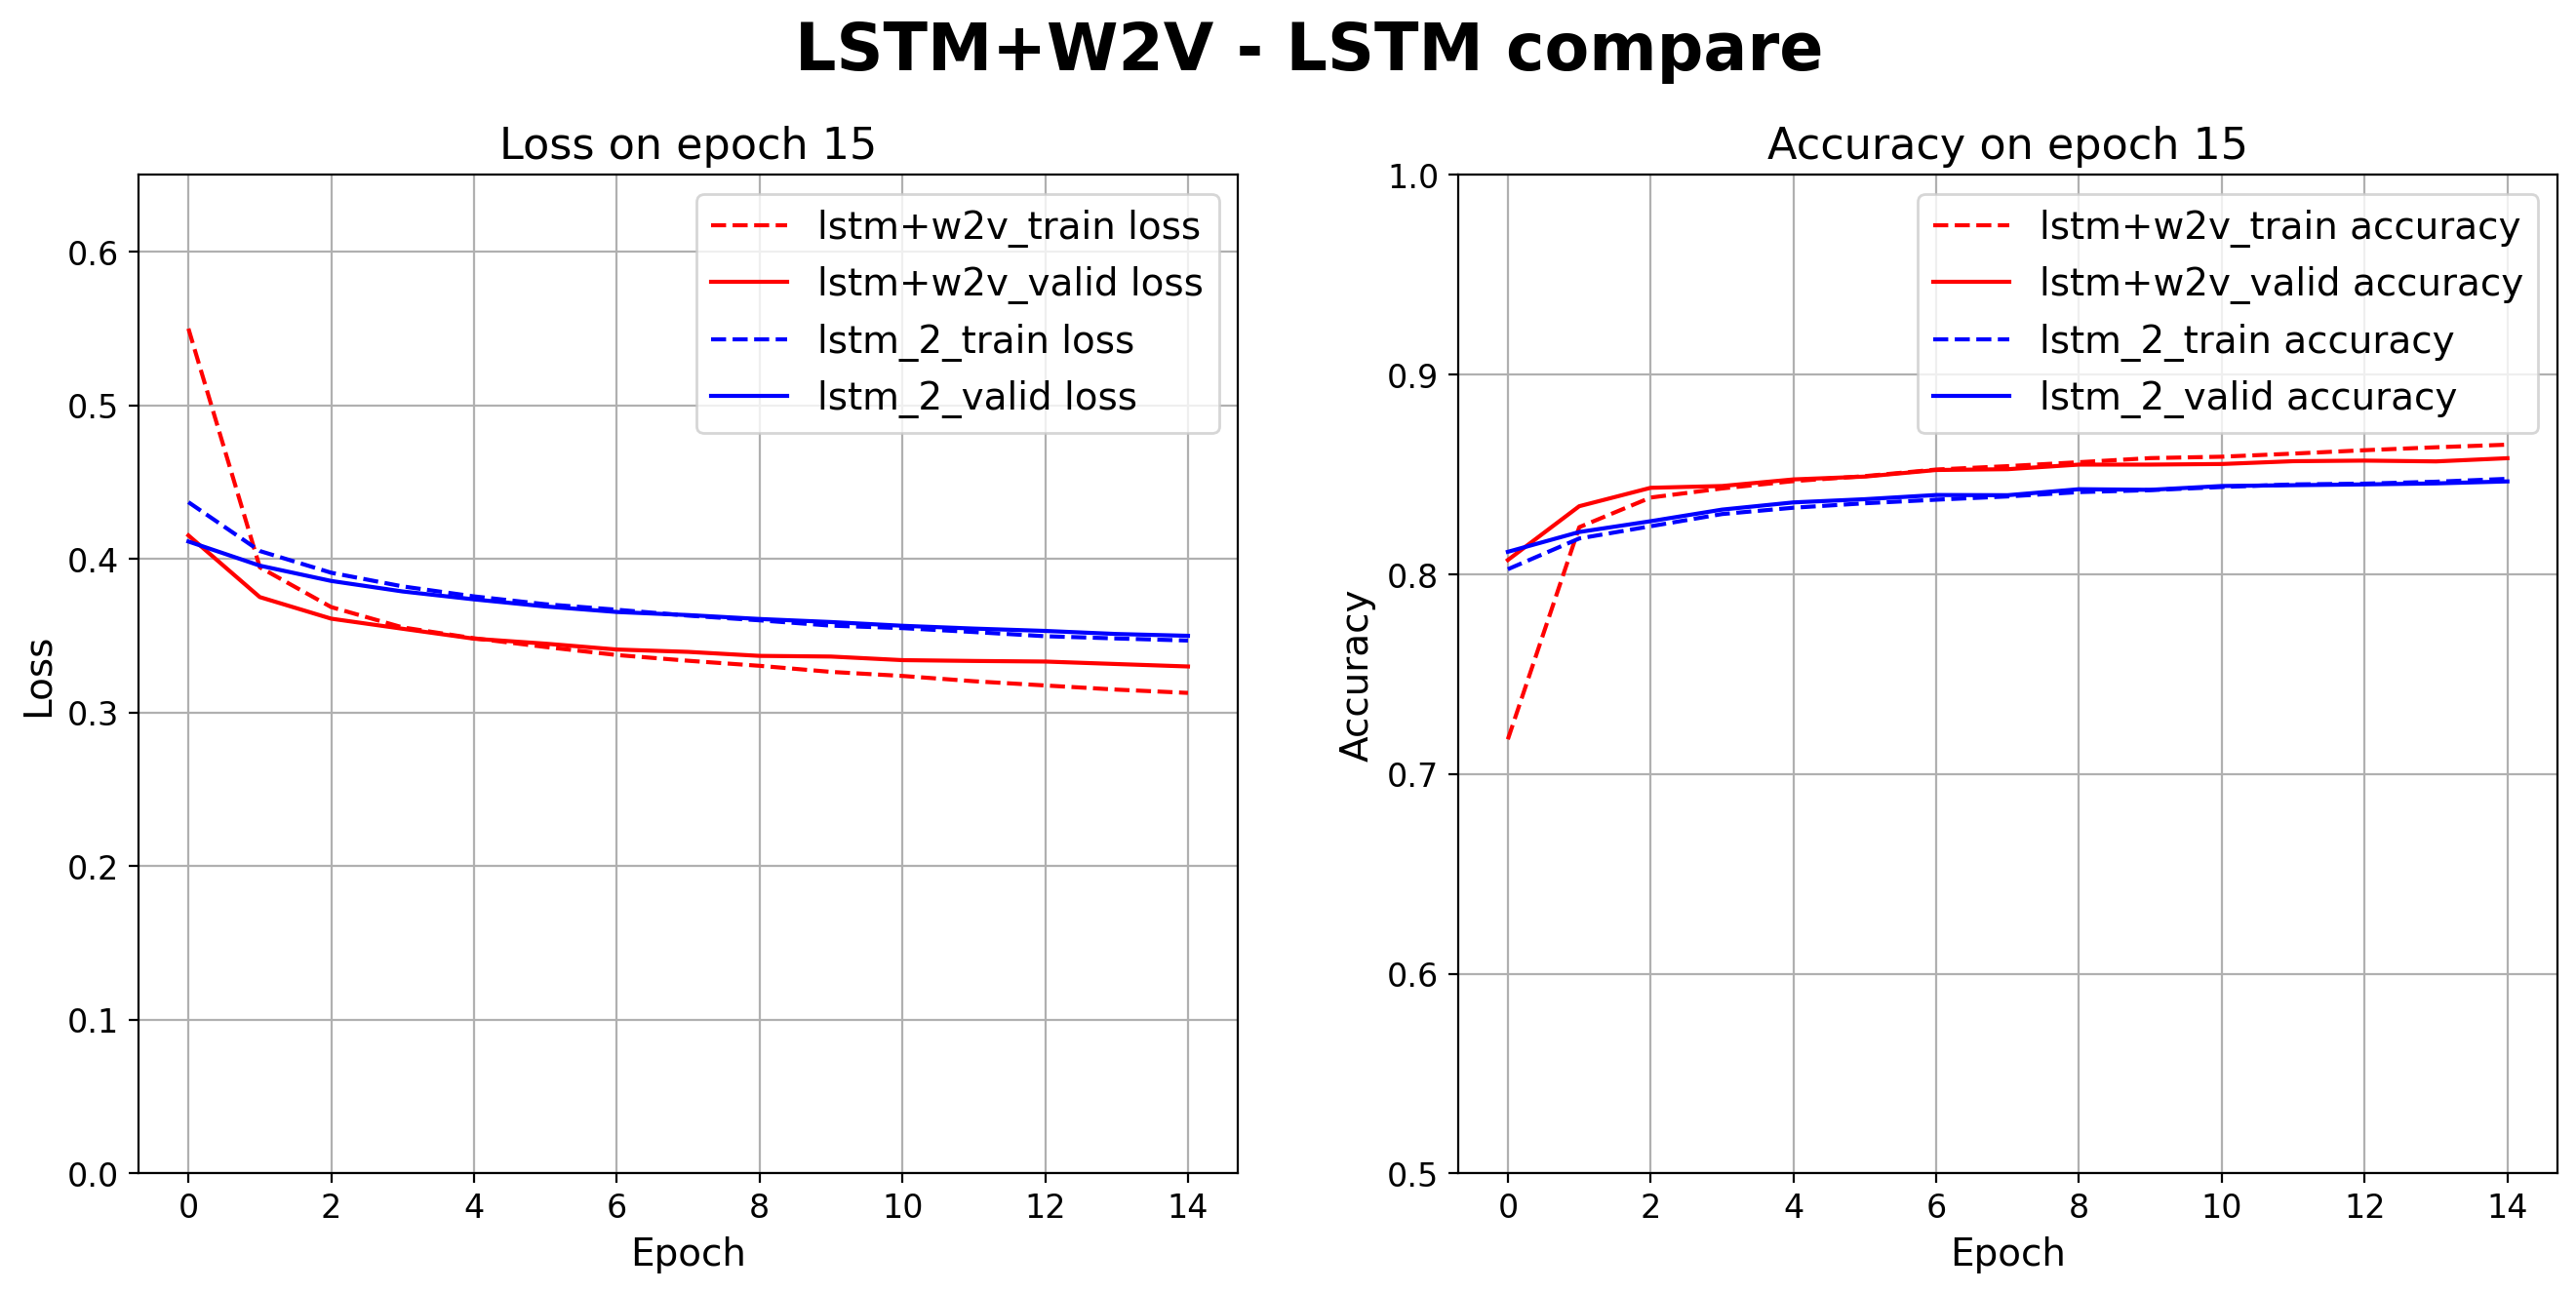

In [48]:
fig3, ax = plt.subplots(1, 2, figsize=(16, 8))
fig3.suptitle("LSTM+W2V - LSTM compare", fontsize=24, fontweight="bold", y=0.85)
ax[0].plot(logs["train_loss"], label="lstm+w2v_train loss", linestyle="--", color="red")
ax[0].plot(logs["valid_loss"], label="lstm+w2v_valid loss", color="red")
ax[0].plot(
    logs_2["train_loss"], label="lstm_2_train loss", linestyle="--", color="blue"
)
ax[0].plot(logs_2["valid_loss"], label="lstm_2_valid loss", color="blue")
ax[0].set_title(f'Loss on epoch {len(logs["train_loss"])}', fontsize=16)
ax[0].grid(True)
ax[0].set_ylim((0, max(logs["train_loss"] + logs["valid_loss"]) + 0.1))
ax[0].legend(fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].set_ylabel("Loss", fontsize=14)

ax[1].plot(
    logs["train_accuracy"], label="lstm+w2v_train accuracy", linestyle="--", color="red"
)
ax[1].plot(logs["valid_accuracy"], label="lstm+w2v_valid accuracy", color="red")
ax[1].plot(
    logs_2["train_accuracy"],
    label="lstm_2_train accuracy",
    linestyle="--",
    color="blue",
)
ax[1].plot(logs_2["valid_accuracy"], label="lstm_2_valid accuracy", color="blue")
ax[1].set_title(f'Accuracy on epoch {len(logs["train_loss"])}', fontsize=16)
ax[1].grid(True)
# ax[0][1].set_ylim((min(history["train_accuracy"]) - 0.05, 1))
ax[1].set_ylim(0.5, 1)
ax[1].legend(fontsize=14)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].set_ylabel("Accuracy", fontsize=14)
plt.subplots_adjust(top=0.75)

In [ ]:
# fig3.savefig("results/W2V_influence.png")


#### Задание 2

Реализуйте функцию, которая иллюстрирует значения оценок attention для разных элементов последовательности. 


In [57]:
def plot_and_predict(review: str, SEQ_LEN: int, model: nn.Module):
    """Predict class and draw word attention scores

    Args:
        review (str): Review text
        SEQ_LEN (int): sequence length
        model (nn.Module): trained model
    """
    print(f"Initial sequence: {review}")
    inp = preprocess_single_string(review, SEQ_LEN, vocab_to_int)
    print(f"Preprocessed sequence: {inp}")
    model.to("cpu")
    model.eval()
    with torch.inference_mode():
        pred, att_scores = model(inp.long().unsqueeze(0))
    print(f"Attention scores: {att_scores.cpu().numpy().flatten()}")

    # create figure
    plt.figure(figsize=(12, 4))
    # draw barplot
    plt.bar(np.arange(len(inp)), att_scores.cpu().numpy().flatten())
    # set ylimits
    plt.ylim(0, max(att_scores.cpu().numpy()[0]) + 0.2)
    # set xticks: seq_len positions with words as labels
    plt.xticks(
        ticks=np.arange(len(inp)),
        labels=[int_to_vocab[x.item()] for x in inp],  # type: ignore
    )
    # Plot title
    plt.title(f"Pred class {pred.sigmoid().round().item()}")
    # set positions and labels under bars
    score_label_shift = len(inp) * 0.02
    for x, y in zip(np.arange(len(inp)), att_scores.detach().cpu().numpy()[0]):
        plt.text(x - score_label_shift, y + 0.005, s=f"{y:.2f}")

In [58]:
vocab_to_int["<pad>"] = 0
int_to_vocab = {j: i for i, j in vocab_to_int.items()}

In [ ]:
# import json

# with open("src/vocab_to_int.json", "w", encoding="utf-8") as f:
#     json.dump(vocab_to_int, f, ensure_ascii=False, indent=4)

Initial sequence: Worst movie I have ever seen
Preprocessed sequence: tensor([  0.,   0., 145.,   1.,  45.,  33.])
Attention scores: [0.04297055 0.04191234 0.21882226 0.26118964 0.2529308  0.18217432]


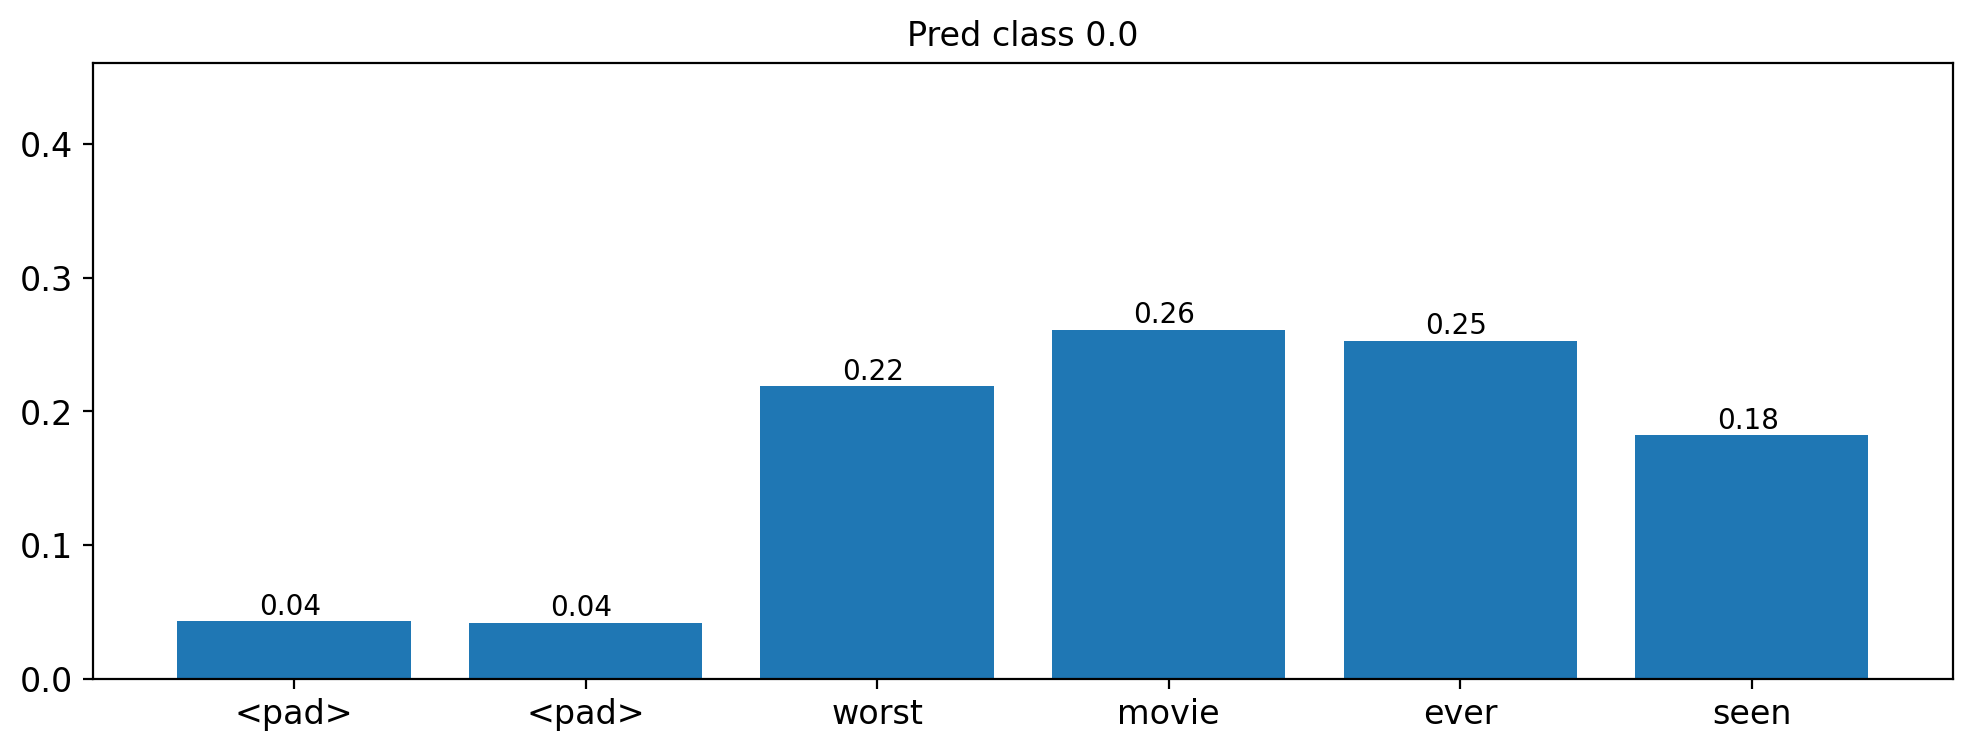

In [61]:
review = "Worst movie I have ever seen"
plot_and_predict(review=review, SEQ_LEN=len(review.split()), model=model_ban)

In [66]:
review_from_chat_gpt = "This movie was a complete disappointment. The plot was predictable and full of clichés, making it hard to stay interested. The acting felt wooden, and the characters had no depth. I honestly regret spending my time watching it."
print(predict_sentence(review_from_chat_gpt, model_ban, test_weights))

(0, 0.0006553223938681185, 'Negative feedback')



#### Задание 3

Используйте самую качественную модель и реализуйте telegram-бота, который принимает на вход пользовательское сообщение и классифицирует его. 